In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonal Convolutions

The aim of this notebook is to reproduce the main results of the paper: "Long range integration in neural networks with orthogonal convolutions."
It is divided in three main sections:
- CIFAR-10
- Receptive fields
- Pathfinder

corresponding to the three main experiments studied in the paper.
In each section, the user can load a pre-trained model and evaluate its performance.
A few of the models showed in the paper are available in this repository, one for each set of parameters.
No training of the models is available here, only evaluation.

The code runs on GPU

In [2]:
%%capture
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import numpy as np
import h5py
from saliency import *
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import load_model
from utils import *
from BilinearInterpolate3D import BilinearInterpolate3D
from OrthogonalConv import NetXCycle

In [4]:
%%capture
gpu_memory_fraction = 0.4
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [5]:
# Set higher to speed up evaluation times, or lower to avoid OOM issues.
BATCH_SIZE = 16

## CIFAR-10

- Load model
- Compile model
- Show model summary
- Load dataset
- Evaluate model

In [7]:
%%capture
cifar_model_path = 'section_4.1/models/baseline_models/baseline_cifar10_depth18.h5'
cifar_dataset_path = 'section_4.1/data/CIFAR-10_test.h5'
cifar_model = load_model(cifar_model_path, custom_objects={'BilinearInterpolate3D':BilinearInterpolate3D})

In [8]:
# Compiling the model
opt_rms = RMSprop(lr=0.001,decay=1e-6)
cifar_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

cifar_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 80)        2240      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 80)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 80)        0         
_________________________________________________________________
bilinear_interpolate3d (Bili (None, 75, 75, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 75)        50700     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 75, 75, 75)        300 

In [9]:
# Load dataset
x_test, y_test = read_h5_dataset(cifar_dataset_path)

In [10]:
# Evaluating 
scores = cifar_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

 1445/10000 [===>..........................] - ETA: 27s - loss: 0.4610 - acc: 0.8830

KeyboardInterrupt: 

## Receptive fields plots
- Load and scale a sample image
- Choose layer list and number of nodes to sample
- Plot receptive field

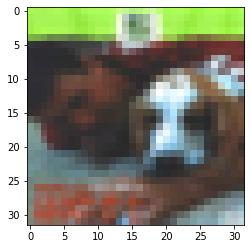

In [16]:
image_index = np.random.randint(0, x_test.shape[0]-1)
image = x_test[image_index]
plt.imshow((image * NORMALIZING_CONST + CENTRALIZING_CONST)/QUANTIZATION_SIZE)


In [17]:
no_of_nodes = 3
layer_list = [2,70]
saliency = get_saliency_maps_and_fitted_ellipses(cifar_model, layer_list, no_of_nodes, image)

number of constant pics: 0


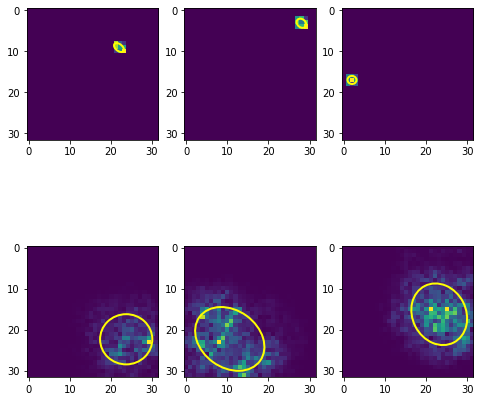

In [18]:
# If a node is deactivated, a blank image will be displayed.
print_images(*saliency)

## Receptive fields stats
- Choose a layer and number of nodes and images to sample.
- Compute and display receptive field statistics. Deactivated nodes do not participate in the statistics.

In [21]:
layer = 42
no_of_images = 2
no_of_nodes = 2
image_indices = np.random.randint(0, x_test.shape[0]-1, size = no_of_images)

In [22]:
sqrt_traces = get_saliency_stats(cifar_model, layer, no_of_nodes, x_test[image_indices])
print(np.mean(sqrt_traces))
print(np.std(sqrt_traces))

2.6991664685058634
0.11600177525052961


## Pathfinder

- Load model from a directory
- (Optional) For large models, run a script to untar and recosntruct the model.
- Compile model
- Show model summary
- Load dataset
- Evaluate model

In [7]:
# Specify the model directory path - no trailing `/` for kernel size 20, otherwise the .h5 file directly
pathfinder_model_path = 'section_4.5/models/orthogonal_models/orthogonal_pathfinder9_kernelsize20'
untar = not bool(pathfinder_model_path.find('.h5')+1)

In [8]:
if untar:
    !sh untar.sh $pathfinder_model_path


orthogonal_pathfinder9_kernelsize20.h5


In [9]:
if untar:
    a = !ls $pathfinder_model_path

In [10]:
if untar:
    model = [i for i in a if i.find('.h5') != -1][0]

In [12]:
%%capture
if untar:
    pathfinder_model_path = pathfinder_model_path + '/' + model

pathfinder_model = load_model(pathfinder_model_path, custom_objects={'BilinearInterpolate3D':BilinearInterpolate3D,
                                                                        'NetXCycle': NetXCycle})
if untar:
    !rm $pathfinder_model_path

In [13]:
pathfinder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     51328     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
net_x_cycle (NetXCycle)      (None, 128, 128, 128)     19662720  
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0     

In [14]:
pathfinder_dataset_path = 'section_4.5/data/pathfinder_path9_test.h5'

In [15]:
# Load dataset
x_test, y_test = read_h5_dataset(pathfinder_dataset_path, scale = False)

In [ ]:
# Evaluating 
scores = pathfinder_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

 5872/10000 [================>.............] - ETA: 27s - loss: 0.4164 - acc: 0.8006